In [2]:
import xarray as xr

# === Paths to your files ===
instant_file = "data_stream-oper_stepType-instant.nc"
accum_file = "data_stream-oper_stepType-accum.nc"
pressure_file = "53b532235fc47f346e14025392cd450f.nc"

# === Helper function to inspect a dataset ===
def inspect_dataset(path):
    print(f"\n📂 File: {path}")
    ds = xr.open_dataset(path)
    print(f"🔸 Variables: {list(ds.data_vars)}")
    print(f"🧭 Coordinates: {list(ds.coords)}")
    print(f"📏 Dimensions: {dict(ds.sizes)}")
    
    # Use 'valid_time' or 'time' if available
    time_coord = 'valid_time' if 'valid_time' in ds.coords else 'time'
    if time_coord in ds.coords:
        print(f"🕓 Time range: {ds[time_coord].values[0]} → {ds[time_coord].values[-1]}")
    else:
        print("⚠️ No time coordinate found.")

    # Sample attributes
    for var in list(ds.data_vars)[:2]:
        print(f"\nℹ️ Variable: {var}")
        print(ds[var])
    
    return ds


# === Inspect each file ===
ds_instant = inspect_dataset(instant_file)
ds_accum = inspect_dataset(accum_file)
ds_pressure = inspect_dataset(pressure_file)


📂 File: data_stream-oper_stepType-instant.nc
🔸 Variables: ['t2m', 'tcc']
🧭 Coordinates: ['number', 'valid_time', 'latitude', 'longitude', 'expver']
📏 Dimensions: {'valid_time': 72, 'latitude': 721, 'longitude': 1440}
🕓 Time range: 2021-07-01T00:00:00.000000000 → 2021-07-03T23:00:00.000000000

ℹ️ Variable: t2m
<xarray.DataArray 't2m' (valid_time: 72, latitude: 721, longitude: 1440)> Size: 299MB
[74753280 values with dtype=float32]
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 576B 2021-07-01 ... 2021-07-03T23...
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      (valid_time) <U4 1kB ...
Attributes: (12/32)
    GRIB_paramId:                             167
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         surface
    GRIB_stepUn

In [1]:
import xarray as xr
import pandas as pd
import numpy as np

# List of solar site metadata
SOLAR_FIELDS = [
    {"name": "Bhadla", "lat": 27.5833, "lon": 71.4333},
    {"name": "Tengger", "lat": 37.3333, "lon": 103.8558},
    {"name": "Benban", "lat": 24.5561, "lon": 32.9016},
    {"name": "Cestas", "lat": 44.7255, "lon": -0.8157},
    {"name": "Balboa", "lat": 38.4533, "lon": -6.2260},
    {"name": "Topaz", "lat": 35.2426, "lon": -120.0096},
    {"name": "DesertSun", "lat": 33.8214, "lon": -115.3939},
    {"name": "Pirapora", "lat": -17.0891, "lon": -44.9878},
    {"name": "Nyngan", "lat": -31.5575, "lon": 147.2031},
]

def extract_site_data(ds, var_list, site, pressure_level=None):
    """Extracts data for a given site from an xarray dataset."""
    lat = site["lat"]
    lon = site["lon"] % 360  # convert to 0-360 if needed
    site_name = site["name"]

    ds_site = ds.sel(latitude=lat, longitude=lon, method="nearest")

    if pressure_level:
        ds_site = ds_site.sel(pressure_level=pressure_level)

    df = ds_site[var_list].to_dataframe().reset_index()
    df["site"] = site_name
    df["latitude"] = lat
    df["longitude"] = lon
    return df


# Load datasets
ds_instant = xr.open_dataset("data_stream-oper_stepType-instant.nc")
ds_accum = xr.open_dataset("data_stream-oper_stepType-accum.nc")
ds_pressure = xr.open_dataset("53b532235fc47f346e14025392cd450f.nc")

# Variables to extract
INSTANT_VARS = ["t2m", "tcc"]
ACCUM_VARS = ["ssrd"]
PRESSURE_VARS = ["q", "t", "cc", "u", "v"]

# Extract for all sites
dfs = []
for site in SOLAR_FIELDS:
    df1 = extract_site_data(ds_instant, INSTANT_VARS, site)
    df2 = extract_site_data(ds_accum, ACCUM_VARS, site)
    df3 = extract_site_data(ds_pressure, PRESSURE_VARS, site, pressure_level=500)

    df_site = df1.merge(df2, on=["valid_time", "site"], how="outer")
    df_site = df_site.merge(df3, on=["valid_time", "site"], how="outer")
    dfs.append(df_site)

# Concatenate all sites
df_all_sites = pd.concat(dfs)

# Optional: convert temperature from K to °C
df_all_sites["t2m"] = df_all_sites["t2m"] - 273.15
df_all_sites["t"] = df_all_sites["t"] - 273.15

# Save
df_all_sites.to_csv("era5_features_sites.csv", index=False)
print("✅ Extracted site-level ERA5 features!")

✅ Extracted site-level ERA5 features!


In [6]:
# === Step 1: Load the saved ERA5 feature file ===
df = pd.read_csv("data/era5_features_sites.csv", parse_dates=["valid_time"])

# === Step 2: Extract one site (e.g., "Bhadla") ===
site_name = "Bhadla"
df_site = df[df["site"] == site_name].copy()
df_site = df_site.sort_values("valid_time")

# === Step 3: Convert accumulated ssrd (J/m²) to irradiance (W/m²) ===
df_site["ssrd_irradiance"] = df_site["ssrd"].diff() / 3600.0  # Assuming hourly
df_site["ssrd_irradiance"] = df_site["ssrd_irradiance"].clip(lower=0)
df_site = df_site.dropna(subset=["ssrd_irradiance"])  # Drop first NaN

# === Step 4: Create the target as next-hour irradiance (t+1) ===
df_site["target"] = df_site["ssrd_irradiance"].shift(-1)
df_site = df_site.dropna(subset=["target"])  # Drop last row with NaN target

# === Step 5: Define features X and target y ===
# Drop unneeded columns
feature_cols = ["t2m", "tcc", "q", "t", "cc", "u", "v"]  # your predictors
X = df_site[feature_cols].copy()
y = df_site["target"].copy()

print("✅ Prepared data shapes:")
print("X:", X.shape)
print("y:", y.shape)


✅ Prepared data shapes:
X: (70, 7)
y: (70,)


✅ RMSE: 21.43 W/m²
✅ R² Score: 0.876


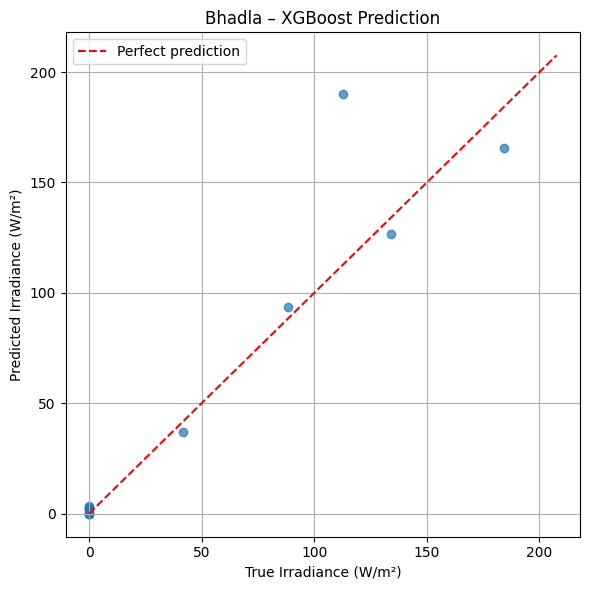

In [7]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# === Step 1: Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# === Step 2: Train XGBoost regressor ===
model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    objective="reg:squarederror",
    random_state=42
)
model.fit(X_train, y_train)

# === Step 3: Predict and evaluate ===
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"✅ RMSE: {rmse:.2f} W/m²")
print(f"✅ R² Score: {r2:.3f}")

# === Step 4: Plot actual vs predicted ===
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label="Perfect prediction")
plt.xlabel("True Irradiance (W/m²)")
plt.ylabel("Predicted Irradiance (W/m²)")
plt.title(f"{site_name} – XGBoost Prediction")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/home/hongjin_zhu/anaconda3/envs/energygrid-predict/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
✅ LSTM RMSE: 58.64 W/m²
✅ LSTM R² Score: 0.068


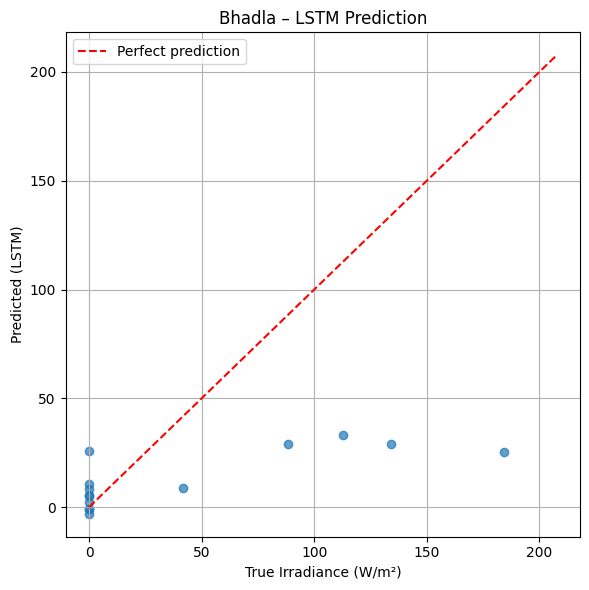

In [12]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler

# === Step 1: Normalize features ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === Step 2: Reshape to 3D for LSTM: (samples, time_steps, features) ===
# We'll use a single timestep input for now (can be expanded later)
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# === Step 3: Build LSTM model ===
model_lstm = Sequential([
    LSTM(64, input_shape=(1, X.shape[1]), return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mse')

# === Step 4: Train the model ===
history = model_lstm.fit(
    X_train_lstm, y_train.values,
    epochs=100,
    batch_size=8,
    validation_split=0.1,
    verbose=0  # Change to 1 to see training output
)

# === Step 5: Evaluate ===
y_pred_lstm = model_lstm.predict(X_test_lstm).flatten()
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
r2_lstm = r2_score(y_test, y_pred_lstm)

print(f"✅ LSTM RMSE: {rmse_lstm:.2f} W/m²")
print(f"✅ LSTM R² Score: {r2_lstm:.3f}")

# === Step 6: Plot ===
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_lstm, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label="Perfect prediction")
plt.xlabel("True Irradiance (W/m²)")
plt.ylabel("Predicted (LSTM)")
plt.title(f"{site_name} – LSTM Prediction")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()